# Covariance Matrix Adaptation Evolution Strategy (CMA-ES)

### 📦 Libraries
```
!pip install cma


### Policy Network for CMA-ES in Gym Environment

In this section, we define a simple policy network using PyTorch. The `PolicyNetwork` class is a neural network that takes the state of the environment as input and outputs an action to be taken. 

#### Key Components:
- **Initialization**: The network consists of two fully connected layers. The first layer transforms the input state to a hidden representation, and the second layer outputs the action.
- **Activation Functions**: We use the ReLU activation function for the hidden layer to introduce non-linearity, and the `tanh` function for the output layer to ensure that the actions are bounded between -1 and 1.
- **Action Retrieval**: The `get_action` method takes a state as input, processes it through the network, and returns the corresponding action.

This network will be used in conjunction with the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) to optimize the policy for a given Gym environment.


In [1]:
import gym


# Create the Mountain Car Continuous environment
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]  # Number of state variables
action_dim = env.action_space.shape[0]      # Number of action variables

print(f"State dimension: {state_dim} | Action dimension: {action_dim}")

State dimension: 2 | Action dimension: 1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 16)
        self.fc2 = nn.Linear(16, action_dim)  # Single output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))  # Use tanh to bound actions in [-1, 1]

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state).cpu().detach().numpy().flatten()
        return action

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the policy network with the appropriate dimensions
policy_net = PolicyNetwork(state_dim, action_dim).to(device)

Using device: cuda


### Policy Evaluation Function

This function evaluates the policy using specified parameters in a given environment.

#### Overview:
- **Parameters**:
  - `params`: Flattened array of parameters for the policy network.
  - `env`: The Gym environment for evaluation.
  - `policy_net`: The policy network to evaluate.
  - `max_steps`: Maximum steps to take during evaluation.

- **Process**:
  1. Apply the flattened parameters to the policy network.
  2. Reset the environment to obtain the initial state.
  3. Generate actions based on the current state and accumulate rewards until termination or the maximum step limit is reached.
  4. Return the total reward and the number of steps taken.

This function is crucial for assessing the performance of the policy network in the specified environment.


In [4]:
def evaluate_policy(params, env, policy_net, max_steps=3000):
    """
    Evaluate the policy using the given parameters in the specified environment.

    Parameters:
    - params: Flattened parameters for the policy network
    - env: The Gym environment to evaluate the policy in
    - policy_net: The policy network to be evaluated
    - max_steps: Maximum number of steps to take in the environment

    Returns:
    - total_reward: Total reward accumulated during the evaluation
    - steps: Number of steps taken before termination
    """
    # Apply parameters to the policy network
    flat_params = torch.tensor(params, dtype=torch.float32).to(device)
    with torch.no_grad():
        start = 0
        for param in policy_net.parameters():
            end = start + param.numel()  # Calculate the end index for the current parameter
            param.copy_(flat_params[start:end].view(param.size()))  # Update parameter values
            start = end  # Move to the next parameter

    total_reward = 0.0  # Initialize total reward
    state, _ = env.reset()  # Reset the environment and get the initial state
    num_steps = 0  # Initialize step counter
    
    while True:
        action = policy_net.get_action(state)  # Get action from the policy network
        state, reward, done, _, _ = env.step(action)  # Take action in the environment
        total_reward += reward  # Accumulate reward
        num_steps += 1  # Increment step counter
        
        # Check for termination conditions
        if done or num_steps > max_steps:
            break
    
    return total_reward, num_steps  # Return total reward and number of steps taken


### CMA-ES Training Loop

This section implements the training loop for the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) to optimize the policy network.

#### Overview:
- **Initialization**: Lists for best, worst, and mean rewards are created, and CMA-ES is initialized with the policy network's parameters.
  
- **Training Process**:
  1. For each generation (up to 100):
     - Generate candidate solutions and evaluate their rewards.
     - Update CMA-ES with the negated rewards.
     - Collect statistics for the current generation.
     - Evaluate and print the best solution found.
  
  2. A stopping criterion is defined based on achieving a reward threshold of 96 for the `MountainCarContinuous-v0` environment.

This loop enables the policy network to evolve and improve its performance over multiple generations.


In [17]:
import cma
import numpy as np
import pandas as pd
import plotly.express as px

def train_cma_es(policy_net, env, max_generations=100, reward_threshold=97):
    # Initialize statistics lists
    metrics = {
        'generation': [],
        'best_reward': [],
        'worst_reward': [],
        'mean_reward': [],
        'steps': []
    }

    # Initialize CMA-ES with the policy network's initial parameters
    initial_params = torch.nn.utils.parameters_to_vector(policy_net.parameters()).detach().cpu().numpy()
    es = cma.CMAEvolutionStrategy(initial_params, 0.5)

    # Training loop for up to max_generations
    for generation in range(max_generations):
        solutions = es.ask()  # Generate candidate solutions
        rewards = []
        
        for solution in solutions:
            # Update policy network parameters and evaluate
            torch.nn.utils.vector_to_parameters(torch.tensor(solution, dtype=torch.float32).to(device), policy_net.parameters())
            reward, st = evaluate_policy(solution, env, policy_net)
            rewards.append(reward)
        
        es.tell(solutions, [-r for r in rewards])  # Update CMA-ES with negated rewards
        es.disp()  # Display CMA-ES status
        
        # Collect statistics
        metrics['generation'].append(generation)
        metrics['best_reward'].append(max(rewards))
        metrics['worst_reward'].append(min(rewards))
        metrics['mean_reward'].append(np.mean(rewards))
        
        # Evaluate the best solution
        best_solution = es.result.xbest
        torch.nn.utils.vector_to_parameters(torch.tensor(best_solution, dtype=torch.float32).to(device), policy_net.parameters())
        best_reward, stp = evaluate_policy(best_solution, env, policy_net)
        metrics['steps'].append(stp)
        print(f"Generation {generation}: Best Reward: {best_reward} | Steps: {stp}")

        # Stopping criterion
        if best_reward >= reward_threshold:  # Threshold for MountainCarContinuous-v0
            break

    return metrics, best_solution


In [8]:
metrics, best_solution = train_cma_es(policy_net, env, max_generations=50)

(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 65 (seed=429469, Thu Aug 22 17:02:30 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -6.818823762358554e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:08.0
Generation 0: Best Reward: -18.88602172410946 | Steps: 3001
    2     32 -8.080884338993511e+01 1.0e+00 4.54e-01  5e-01  5e-01 0:16.2
Generation 1: Best Reward: 81.98980967124015 | Steps: 1758
    3     48 -6.248644235072485e+01 1.0e+00 4.45e-01  4e-01  4e-01 0:23.8
Generation 2: Best Reward: 79.05661149546195 | Steps: 1581
    4     64 -4.724998688227066e+01 1.1e+00 4.37e-01  4e-01  4e-01 0:31.8
Generation 3: Best Reward: 82.41907412520638 | Steps: 1586
    5     80 -7.872297283210926e+01 1.1e+00 4.26e-01  4e-01  4e-01 0:38.5
Generation 4: Best Reward: 77.9497937819159 | Steps: 1801
    6     96 -7.581921342467265e+01 1.1e+00 4.16e-01  4e-01  4e-01 0:44.2
Generation 5: Best Reward: 80.5835996538988 | Steps: 1894
    7    112 -7.409313872905439e+01 1.1

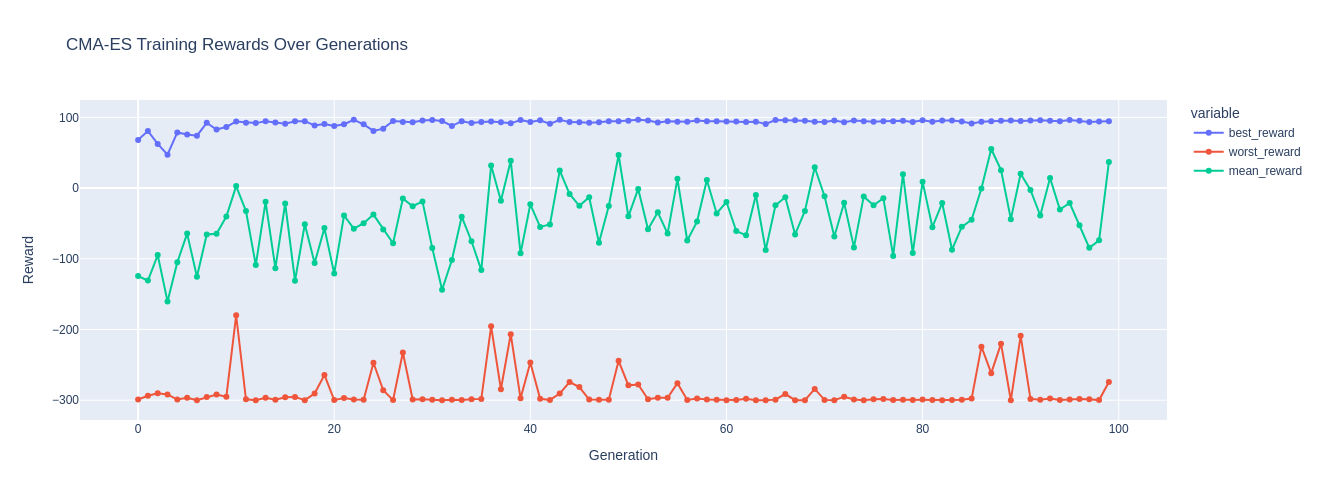

In [15]:
# Convert metrics to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plotting the results using Plotly
fig = px.line(df_metrics, x='generation', y=['best_reward', 'worst_reward', 'mean_reward'],
              title='CMA-ES Training Rewards Over Generations',
              labels={'value': 'Reward', 'generation': 'Generation'},
              markers=True)
fig.update_layout(height=500, width=1100)
fig.show()

### Policy Testing

This section tests the performance of the trained policy network using the best parameters obtained from the CMA-ES optimization.

##### Overview:
- **Parameter Loading**: The best parameters are loaded into the policy network.
- **Environment Setup**: The `MountainCarContinuous-v0` environment is created for testing.

In [23]:
import gym
import torch
import numpy as np

# Create the environment for testing and wrap it to record video
env = gym.make('MountainCarContinuous-v0', render_mode='human')
env = gym.wrappers.RecordVideo(env, 'videos/', name_prefix='test_policy', episode_trigger=lambda x: True)

def test_policy(env, policy_net):
    state, _ = env.reset()  # Reset the environment
    done = False
    total_reward = 0
    cnt = 0  # Step counter

    while not done:
        env.render()
        action = policy_net.get_action(state)  # Get action from the policy network
        state, reward, done, _, _ = env.step(action)  # Take action in the environment
        total_reward += reward  # Accumulate reward
        cnt += 1  # Increment step counter

    env.close()  # Close the environment
    print(f"Total steps: {cnt}")
    return total_reward  # Return total reward

# Run the test with the best parameters loaded
test_reward = test_policy(env, policy_net)
print(f"Total Reward during test: {test_reward}")

/home/bruno/anaconda3/envs/python9/lib/python3.9/site-packages/gym/wrappers/record_video.py:75: UserWarning:

WARN: Overwriting existing videos at /home/bruno/Documents/World Model/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)

/home/bruno/anaconda3/envs/python9/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning:

WARN: Disabling video recorder because environment <TimeLimit<OrderEnforcing<PassiveEnvChecker<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`

/home/bruno/anaconda3/envs/python9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



Total steps: 354
Total Reward during test: 95.81873742646476
